In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
from keras.applications.vgg16 import VGG16
vgg = VGG16(include_top=False, input_shape=(224, 224, 3))
vgg.summary()

Using TensorFlow backend.
/Users/geoff/PycharmProjects/Tibame_Online_Course/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/geoff/PycharmProjects/Tibame_Online_Course/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/geoff/PycharmProjects/Tibame_Online_Course/venv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint1


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0    

In [3]:
import glob
import pandas as pd
# 先不讀取圖片，真的要訓練才讀
df = pd.DataFrame(columns=["path", "target"])
for p in glob.glob("train/cat.*.jpg"):
    s = pd.Series([p, 0], index=["path", "target"])
    df = df.append(s, ignore_index=True)
for p in glob.glob("train/dog.*.jpg"):
    s = pd.Series([p, 1], index=["path", "target"])
    df = df.append(s, ignore_index=True)
df

,path,target
0,train/cat.5077.jpg,0
1,train/cat.2718.jpg,0
2,train/cat.10151.jpg,0
3,train/cat.3406.jpg,0
4,train/cat.4369.jpg,0
...,...,...
24995,train/dog.9316.jpg,1
24996,train/dog.6025.jpg,1
24997,train/dog.8008.jpg,1
24998,train/dog.1992.jpg,1


train/dog.1063.jpg
(349, 290)


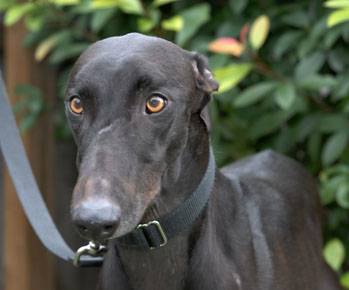

In [4]:
from keras.preprocessing.image import load_img
import random
c = random.randint(0, 24999)
print(df["path"][c])
img = load_img(df["path"][c])
print(img.size)
img

(224, 224)


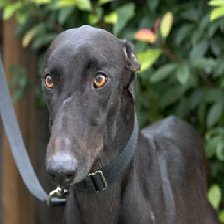

In [5]:
img = load_img(df["path"][c], target_size=(224, 224))
print(img.size)
img

In [6]:
from keras.models import Model
from keras.layers import Flatten, Dense, BatchNormalization
# CNN(眼睛)
for l in vgg.layers: # 將vgg的layers參數固定住
    l.trainable = False
# BN(血管)
x = BatchNormalization()(vgg.output)
# MLP(大腦)
x = Flatten()(x)
x = Dense(units=2048, activation="relu")(x)
x = Dense(units=256, activation="relu")(x)
# 貓和狗分類：units = 1, units = 2 都可以
# 若units=1 -> sigmoid, 若units=2 -> softmax
x = Dense(units=2, activation="softmax")(x)
cnn = Model(inputs=vgg.input, outputs=x) # input output都是向量
cnn.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [7]:
vgg.layers

In [8]:
# 確認訓練方式
cnn.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [9]:
from sklearn.model_selection import train_test_split
# 真的要開始切分和訓練時，先把pandas轉成numpy的array
# 先處理一下答案，轉化成為One-hot encoding
from keras.utils.np_utils import to_categorical
y_cat = to_categorical(df["target"])
import numpy as np
x_train, x_test, y_train, y_test = train_test_split(np.array(df["path"]),
                                                    np.array(y_cat),
                                                    test_size=0.1)
# show一個y_train
y_train[0]

array([1., 0.], dtype=float32)

In [10]:
x_train.shape

(22500,)

In [11]:
# 你偷誰的模型，就要使用他的預處理方式
from keras.applications.vgg16 import preprocess_input
batch_size = 10
for i in range(30):
    # randint(下限(包括), 上限(不包括), 幾個)
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    # numpy好用之處：array[ 索引list ]
    imglist = []
    for fn in x_train[idx]:
        # 讀取圖片並且使用我們偷來的模型的預處理方式處理
        img = load_img(fn, target_size=(224, 224))
        img = preprocess_input(np.array(img))
        imglist.append(img)
    x = np.array(imglist)
    y = y_train[idx]
    result = cnn.train_on_batch(x, y)
    print("-----Times", i, "-----")
    print(result)


-----Times 0 -----
[1.137522, 0.3]
-----Times 1 -----
[0.9088496, 0.7]
-----Times 2 -----
[11.590573, 0.7]
-----Times 3 -----
[1.7769979, 0.5]
-----Times 4 -----
[0.00035537727, 1.0]
-----Times 5 -----
[4.872281, 0.8]
-----Times 6 -----
[16.921988, 0.6]
-----Times 7 -----
[13.845003, 0.5]
-----Times 8 -----
[1.0860809, 0.9]
-----Times 9 -----
[0.9209032, 0.8]


In [12]:
batch_size = 100

# randint(下限(包括), 上限(不包括), 幾個)
idx = np.random.randint(0, x_test.shape[0], batch_size)
# numpy好用之處：array[ 索引list ]
imglist = []
oriimglist = []
for fn in x_test[idx]:
    # 讀取圖片並且使用我們偷來的模型的預處理方式處理
    img = load_img(fn, target_size=(224, 224))
    # 先把原圖留下來
    oriimglist.append(img)
    img = preprocess_input(np.array(img))
    imglist.append(img)
x = np.array(imglist)
y = y_test[idx]
cnn.evaluate(x, y)

100/100 [==============================] - 32s 321ms/step


[4.632955207824707, 0.8299999833106995]

In [13]:
# cnn.predict(x) # 可見機率都長得一樣，不合理(回頭加上BatchNormalization)

In [14]:
pre = cnn.predict(x).argmax(axis=-1)
pre

array([1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1])

In [15]:
y.argmax(axis=-1)

array([1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1])

In [16]:
np.nonzero(pre != y.argmax(axis=-1))

(array([ 1,  3,  5,  8, 23, 25, 28, 33, 39, 40, 52, 66, 70, 72, 78, 92, 96]),)